# Computing Brachistochrones with JAX

## Imports and helpers

In [1]:
import jax.numpy as jnp
from flax import struct
from jax import value_and_grad, jit
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
def fix_ends(vec,a,b):
  return vec.at[0].set(a).at[-1].set(b)

## Define struct to configure the experiment + optimization parameters

In [64]:
@struct.dataclass
class Config:
  num_segments: int
  y_start: float
  y_end: float
  x_end: float
  g: float
  v0: float
  min_delta: float
  iter_max: int
  learning_rate: float
  clip_grad: float
  clip_y: float

## Implement computing the time it takes to slide down the ramp

The slide is discretized into a vector r[i] describing the `y`-offset at equidistant spaces.

```
           ____ ____ ____ ____
y_start - | ## |    |    |    |
          | ## |    |    |    |
          | ## |    |    |    |
          | ## | ## |    |    |
          | ## | ## |    |    |
          | ## | ## |    |    |
          | ## | ## | ## |    |
          | ## | ## | ## |    |
y_end   - +----+----+----+----+
           r[0] r[1] r[2] r[3]
```

* The length of the ramp from `r[i-1]` to `r[i]` is the diagonal: `length[x] = (delta_y)^2 + (delta_x)^2`
* The potential energy is `E_pot = m*g*h` and the kinetic energy is `E_kin=1/2*m*v^2` where `v` is the speed.
* Based on the above, the speed at height `h` is `v[i] = sqrt(2*g*delta_h[i])` where `delta_h[i]` is the height difference to the highest point of the ramp.
* The speed at the midpoint between `i-1` and `i` is `1/2 * (v[i-1]+v[i])`
* The time needed for one segment is `length / speed`
* The overall time is the sum over the times of all segments

In [3]:
def get_slide_time(ramp, config):
  ramp_left = jnp.roll(ramp, 1).at[0].set(config.y_start)

  delta_x = config.x_end / config.num_segments
  delta_y = (ramp - ramp_left)
  length = jnp.sqrt((delta_x) ** 2 + (delta_y) ** 2).at[0].set(0)

  speed_left = config.v0 + jnp.sqrt(2 * config.g * (config.y_start - ramp_left))
  speed_right = config.v0 + jnp.sqrt(2 * config.g * (config.y_start - ramp))
  speed = 1/2 * (speed_left + speed_right)

  return jnp.sum(length/speed)

get_slide_time = jit(get_slide_time)
get_slide_time_and_grad = jit(value_and_grad(get_slide_time, argnums=0))

## Implement one iteration of gradient descent

In [4]:
def gradient_descent_iteration(ramp, config):
  slide_time, ramp_grad = get_slide_time_and_grad(ramp, config)
  
  ramp_update = config.learning_rate * ramp_grad
  ramp_update = jnp.clip(ramp_update, -config.clip_grad, config.clip_grad)
  ramp_update = fix_ends(ramp_update, 0, 0) # No updates and the end-points.

  ramp -= ramp_update
  ramp = jnp.clip(ramp, -config.clip_y, config.y_start)
  ramp = fix_ends(ramp, config.y_start, config.y_end)

  return ramp, ramp_update, slide_time

gradient_descent_iteration = jit(gradient_descent_iteration)

## Plotting

In [59]:
def plot_ramps(config, ramps, iteration, time):
  ymin = min([jnp.min(ramp[0]) for ramp in ramps]) - 0.05
  ymax = max(ramps[-1][0])
  plt.clf()
  plt.title(f"X_end: {config.x_end:.01f}, Y_start: {config.y_start:.01f}, Slide Time: {time:.03f}, Iterations: {iteration}")
  plt.xlim([-0.05,config.x_end + 0.05])
  plt.ylim([ymin,ymax])
  print(ymax)
  for i, (ramp, iteration) in enumerate(ramps, start=1):
    rel_iter = 1.0 - i / len(ramps)
    col = (rel_iter, rel_iter, rel_iter)
    plt.plot(jnp.arange(0,config.x_end,(config.x_end)/config.num_segments), ramp, color=col)

## Configure the experiment

In [62]:
config = Config(num_segments=1000, y_start = 1.0, y_end = 0.0, x_end = 3.0, g = 9.81, v0=0.001, min_delta = 0.001, learning_rate = 0.003, iter_max=50000000, clip_grad = 0.1, clip_y = 50.0)

## Run the optimization and plot the results

0it [00:00, ?it/s]

1.0


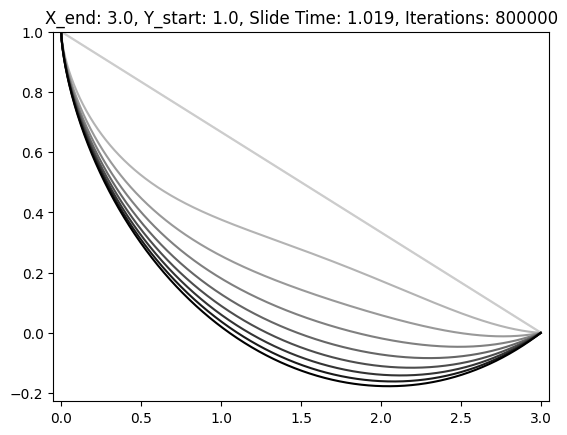

In [67]:
pbar = tqdm(mininterval=0.2)

last_slide_time = 0.0
cur_slide_time = 0.0

ramp = jnp.arange(config.y_start,config.y_end,(config.y_end-config.y_start)/config.num_segments, dtype=jnp.float32)
ramps = [(ramp,0)]

while True:
  ramp_new, grad, cur_slide_time = gradient_descent_iteration(ramp, config)
  if pbar.n > config.iter_max:
    break
  if pbar.n % 100000 == 0:
    ramps.append((ramp,pbar.n))
    pbar.set_description(f"iteration: {pbar.n}, slide time: {cur_slide_time:.6f}, slide time delta: {cur_slide_time-last_slide_time:.8f}", refresh=False)
    if last_slide_time > 0 and abs(last_slide_time - cur_slide_time) < config.min_delta:
      pbar.set_description(f"stopping early since optimization criterion improved less than {config.min_delta}")
      break
    last_slide_time = cur_slide_time
  ramp = ramp_new
  pbar.update(1)

plot_ramps(config, ramps, pbar.n, last_slide_time)